### Momentum & Nesterov accelerated gradient
(Reference: 딥러닝을 위한 최적화와 수치해석, 남가람북스)

- 그래디언트 반대방향을 사용하는 것에서 발전된 방법.

- local minimum이 많은 loss functiond에서 성능향상이 될 수 있음.

- Gradient descent method는 local minimum으로 수렴하게 되면 더는 빠져나올 수 없음. (즉, global minimum으로 수렴할 수 없음)
    - local minimum 위치에서 탐색방향의 반대인 gradient 크기가 0이기 때문.
    
    
-----
- Momentum & Nesterov acceleated gradient는 모두 **local minimum을 지나 더 작은 손실함숫값을 가지는 local minimum으로 갈 가능성이 높아지는 방법**

- **탐색 방향으로** 단순히 gradient를 사용하는 것이 아닌, **전 단계의 탐색 방향의 누적합에 현재 단계의 gradient descent방법의 탐색 방향을 더한 값을 사용** 
   - $\Rightarrow$ 임의의 local minimum에서도 탐색 방향이 0이 아니게 됨.

- 하지만, 계속 더하기만 할 경우에는 한참 전 단계의 탐색 방향의 크기가 누적되어 알고리즘 전체에 영향을 미침.
    - $\rightarrow$ 전 단계까지의 탐색 방향의 누적합에 일정한 상수 $0 \leq \mu \leq 1$를 곱한 후 현재의 gradient를 더해줌.
    
    - $0 \leq \mu \leq 1$ : 오래전 단계의 탐색 방향을 작게 해주는 역할
    - $\mu v^{(t)}$ : 현 위치의 $\nabla E(w^{(k)}$를 이용하지 않고, 현 위치에서 속도($\mu v^{(t)}$)만큼 전진한 후 $\nabla E \left( w^{(k)} + \mu v^{(k)} \right)$를 이용함
    > $v^{(k+1)} = \mu v^{(k)} - \epsilon \nabla E \left( w^{(k)} + \mu v^{(k)} \right)$
    >
    > $w^{(k+1)} = w^{(k)} + v^{(k+1)}$
    
    

------

#### Nesterov accelerated gradient

> 1) 초깃값 $w^{(0)}$ & 단기 누적속도 합 $v^{(0)} = 0$으로 초기화
>
> 2) 전체 데이터를 임의로 섞어줌 (shuffling)
>
> 3) 전체 데이터에서 개수가 $m$개인 부분집합(batch)들을 만듬
>
> 4) 각 부분집합마다 다음을 반복함.
>
>     4-1) 부분집합으로 gradient를 현재 위치($w^{(k)}$)에서 계산함.
>
>     4-2) 주어진 학습률 $\epsilon$을 사용
>
>     4-3) 탐색방향을 $v^{(k+1)} = \mu v^{(k)} - \epsilon \nabla E \left( w^{(k)} + \mu v^{(k)} \right)$으로 설정
>
>     4-4) 파라미터 추정치를 업데이트: $w^{(k+1)} = w^{(k)} + v^{(k+1)}$
>
> 5) 만들어진 부분집합을 모두 사용한 후 다시 4)를 epoch번 반복함

----

-----

In [1]:
import numpy as np
np.random.seed(0)

In [2]:
def generate_batches(batch_size, features, labels):
    outout_batches = []
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
    return outout_batches

#### loss

$loss = 0.5 * 1/{N} \sum_{}^{N}(w_{0}x_{i} + w_{1} - y_{i})^{2}$

In [3]:
def loss(w, x_set, y_set):
    N = len(x_set)
    val = 0.0
    for i in range(len(x_set)):
        val += 0.5 * (w[0] * x_set[i] + w[1] - y_set[i])**2
        
    return val/N

#### loss_grad

$\nabla_{w_{0}} loss = 1/N \sum^{N}(w_{0}x_{i} + w_{1} - y_{i})*x_{i}$

$\nabla_{w_{1}} loss = 1/N \sum^{N}(w_{0}x_{i} + w_{1} - y_{i})$

In [4]:
def loss_grad(w, x_set, y_set):
    N = len(x_set)
    val = np.zeros(len(w))
    for i in range(len(x_set)):
        er = w[0] * x_set[i] + w[1] - y_set[i]
        val += er * np.array([x_set[i], 1.0])
    return val/N

----

### Nesterov accelerated gradient 

In [5]:
f = lambda x: 0.5 * x + 1.0
x_train = np.linspace(-1, 1, 50)
y_train = f(x_train) + 0.4 * np.random.rand(len(x_train))

In [6]:
batch_size = 5   # 배치 크기 (m)
epsilon = 0.03  # 학습률 (epsilon)
MaxEpochs = 10   # 반복 횟수 (epochs)

# 1) 초기값 (w0)
w0 = np.array([4.0, -1.0])  

In [7]:
alpha = 0.9
velocity = np.zeros_like(w0)   # 단기 누적속도 합 v0 = 0
paths = []
batch_loss = []

In [8]:
# 2) 데이터 셔플링
np.random.seed(0)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffled_x_train = x_train[idx]
shuffled_y_train = y_train[idx]

In [9]:
## 알고리즘
for epoch in range(MaxEpochs+1):  # 5) MaxEpochs번 반복
    # 3) 미니 배치 생성 (전체 데이터에서 개수가 m개인 부분집합(batch)를 만듬)
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        # 4-1) 미니 배치에서 그래디언트 계산 (부분집합으로 gradient를 현재위치(w_k)에서 계산)
        grad = loss_grad(w0 + alpha * velocity, x_batch, y_batch)
        # 4-2) 학습률(epsilon) 설정
        epsilon = epsilon 
        # 4-3) 탐색 방향 설정 (v_(k+1))
        velocity = alpha * velocity - epsilon * grad
        dw = velocity
        w0 = w0 + dw
    print('{:02d}\t{}\t{:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))

00	[2.77401609 0.96551501]	0.9669
01	[0.99304674 1.80060765]	0.2266
02	[0.11444414 1.2221911 ]	0.0262
03	[0.04519558 1.06316135]	0.0468
04	[0.27004957 1.22736329]	0.0119
05	[0.45276302 1.25304669]	0.0064
06	[0.51285306 1.20805015]	0.0062
07	[0.49816619 1.20531059]	0.0060
08	[0.46874881 1.21708631]	0.0057
09	[0.45243077 1.21676222]	0.0056
10	[0.45004165 1.21381238]	0.0056


In [10]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [11]:
w0 = np.linspace(-5, 7, 101)
w1 = np.linspace(-2, 5, 101)
w0, w1 = np.meshgrid(w0, w1)
loss_w = w0 * 0

for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i, j], w1[i, j]])
        loss_w[i, j] = loss(wij, x_train, y_train)

(-5.0, 7.0, -2.0, 5.0)

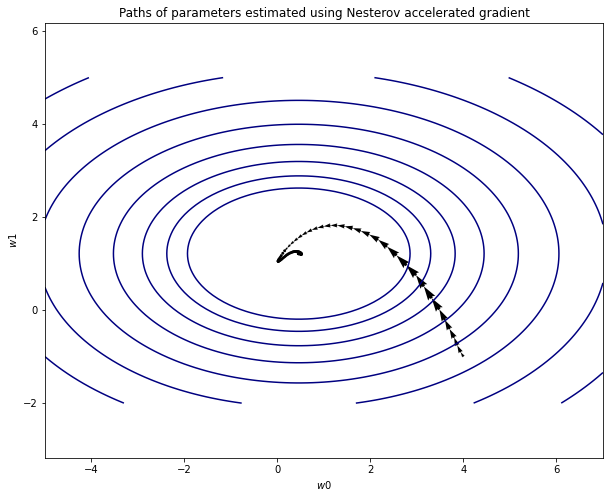

In [12]:
paths = np.array(paths)
paths = np.array(np.matrix(paths)).T

fig, ax = plt.subplots(figsize = (10, 8))
ax.contour(w0, w1, loss_w, levels = np.logspace(0, 5, 35), 
           cmap = plt.cm.jet)
ax.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1],
          scale_units = 'xy', angles = 'xy', scale = 1, color = 'k')
ax.set_xlabel('$w0$')
ax.set_ylabel('$w1$')
ax.set_title('Paths of parameters estimated using Nesterov accelerated gradient')
ax.axis('equal')

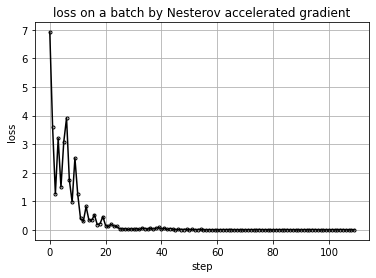

In [13]:
plt.plot(batch_loss, '.-k', markerfacecolor = 'none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Nesterov accelerated gradient')
plt.show()

-----

-----